In [1]:
import time
import numpy as np
import pandas as pd
import random
import torch as t
import copy
from fastcore.foundation import patch
import matplotlib.pyplot as plt

from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader

from nixtla.models.esrnn.rnn import RNN

In [2]:
from nixtla.data.datasets.epf import EPF, EPFInfo
Y_df, X_df, _ = EPF.load(directory='../data', group=EPFInfo.groups[0])

X_df = X_df[['unique_id', 'ds', 'Exogenous1', 'Exogenous2', 'week_day']]

epf_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=24)
epf_dataset_full = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df, ts_in_test=0)

In [3]:
train_loader = TimeSeriesLoader(ts_dataset=epf_dataset,
                                model='rnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)
test_loader = TimeSeriesLoader(ts_dataset=epf_dataset_full,
                                model='esrnn',
                                offset=0,
                                window_sampling_limit= 24*30,
                                input_size=7*24,
                                output_size=24,
                                idx_to_sample_freq=24,
                                complete_inputs=True,
                                complete_sample=False,
                                batch_size=1,
                                shuffle=True)

In [4]:
model = RNN(input_size=7*24,
            output_size=24,
            include_var_dict={'Exogenous1':[-8,-2,-1], 'Exogenous2':[-8,-2,-1], 'week_day':[-1]}, # 
            t_cols=epf_dataset.t_cols,
            max_epochs=1_000,
            learning_rate=1e-2,
            lr_scheduler_step_size=200,
            lr_decay=0.9,
            gradient_eps=1e-8,
            gradient_clipping_threshold=20,
            rnn_weight_decay=0,
            noise_std=0.001,
            testing_percentile=50,
            training_percentile=50,
            cell_type='LSTM',
            state_hsize=200,
            dilations=[[1, 2], [4, 8]],
            add_nl_layer=False,
            loss='MAE',
            random_seed=1,
            device='cpu')

In [5]:
model.fit(train_ts_loader=train_loader, eval_epochs=100, verbose=True)

Infered frequency: H
=============== Training ESRNN  ===============

Epoch: 0, Time: 0.050, Insample loss: 52.29592
Epoch: 100, Time: 4.443, Insample loss: 3.59665
Epoch: 200, Time: 8.889, Insample loss: 1.81373
Epoch: 300, Time: 13.390, Insample loss: 1.23071
Epoch: 400, Time: 17.806, Insample loss: 0.95349
Epoch: 500, Time: 22.255, Insample loss: 0.76997
Epoch: 600, Time: 26.715, Insample loss: 0.73893
Epoch: 700, Time: 31.251, Insample loss: 0.60292
Epoch: 800, Time: 35.858, Insample loss: 0.56457
Epoch: 900, Time: 40.338, Insample loss: 0.47641


In [6]:
y_true, y_hat, y_mask = model.predict(ts_loader=test_loader, eval_mode=True)

In [7]:
y_hat_flatten = y_hat[:,-20:,:].flatten()
y_hat_flatten.shape

(480,)

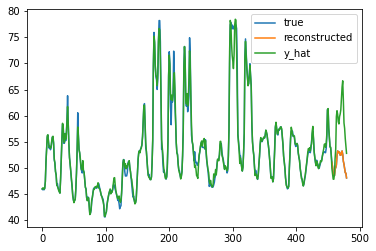

In [8]:
y_plot = Y_df['y'][-20*24:]
plt.plot(range(len(y_plot)), y_plot, label='true')
plt.plot(range(len(y_plot)-len(y_true[0,-1,:]),len(y_plot)), y_true[0,-1,:], label='reconstructed')
plt.plot(range(len(y_hat_flatten)), y_hat_flatten, label='y_hat')
plt.legend()